In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

# EDA Approach

We are going to explore how each variable effects whether or not someone smokes.  The variable exploration will help us identify which variables we want to include in our model.  After we explore each categorical variable, we will attempt to build a model that predicts whether or not an indoor worker is a smoker.

In [2]:
df = pd.read_csv('SmokeBan.csv')
df.drop(labels=['Unnamed: 0'], axis = 1, inplace = True)
df.head()

,smoker,ban,age,education,afam,hispanic,gender
0,yes,yes,41,hs,no,no,female
1,yes,yes,44,some college,no,no,female
2,no,no,19,some college,no,no,female
3,yes,no,29,hs,no,no,female
4,no,yes,28,some college,no,no,female


In [3]:
df.isna().sum()

smoker       0
ban          0
age          0
education    0
afam         0
hispanic     0
gender       0
dtype: int64

In [4]:
df.education.value_counts()

hs              3266
some college    2802
college         1972
master          1048
hs drop out      912
Name: education, dtype: int64

In [5]:
df.afam.value_counts()

no     9231
yes     769
Name: afam, dtype: int64

In [6]:
df.hispanic.value_counts()

no     8866
yes    1134
Name: hispanic, dtype: int64

In [7]:
df.gender.value_counts()

female    5637
male      4363
Name: gender, dtype: int64

In [8]:
# let's replace each column with numerics so that we can plot the variables against each other
num_df = df.copy()

num_df.smoker.replace({'yes': 1, 'no': 0}, inplace= True)
num_df.ban.replace({'yes': 1, 'no': 0}, inplace = True)
num_df

,smoker,ban,age,education,afam,hispanic,gender
0,1,1,41,hs,no,no,female
1,1,1,44,some college,no,no,female
2,0,0,19,some college,no,no,female
3,1,0,29,hs,no,no,female
4,0,1,28,some college,no,no,female
...,...,...,...,...,...,...,...
9995,0,0,55,hs,no,no,male
9996,0,0,31,master,no,no,male
9997,0,1,36,some college,no,no,female
9998,1,0,42,hs,no,no,female


In [9]:
num_df.columns

Index(['smoker', 'ban', 'age', 'education', 'afam', 'hispanic', 'gender'], dtype='object')

In [10]:
df.isna().sum()

smoker       0
ban          0
age          0
education    0
afam         0
hispanic     0
gender       0
dtype: int64

# Categorical Variable Exploration

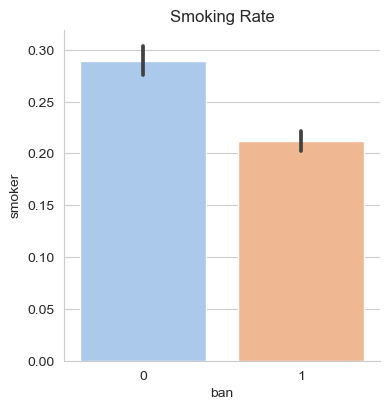

In [11]:
sns.catplot(data = num_df, x = 'ban', y = 'smoker', kind = 'bar', height = 4, aspect = 1)
plt.title("Smoking Rate")
plt.show()

<h3>Ban Effect:</h3>
<p style="color: blue; font-size: 16px">It does initially appear that smoking bans have some effect on whether an individual smokes.  Workers smoke only ~21% of the time where workplace bans are in effect compared with ~29% of the time when they are not in effect.</p>

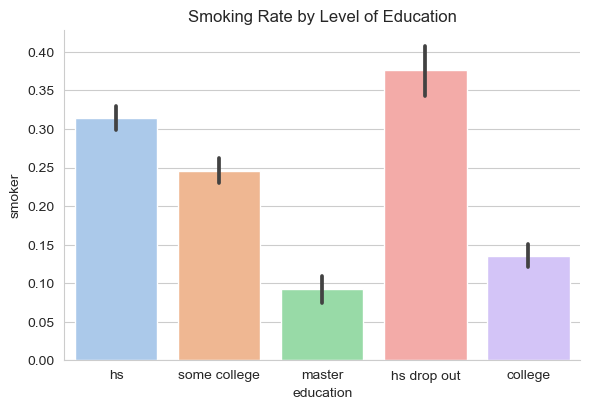

In [12]:
sns.catplot(data = num_df, x = 'education', y = 'smoker', kind = 'bar', height = 4, aspect = 1.5)
plt.title("Smoking Rate by Level of Education")
plt.show()

<h3>Education Effect</h3>
<p style="color: blue; font-size: 16px;">There seems to be a significant correlation between the level of education of an individual and how likely they are to smoke.  With each step up in level of education, a person is likely to smoke.  This is highlighted by the fact that over 35% of high school drop outs smoke while less than 10% of individuals with a masters degree smoke.</p>

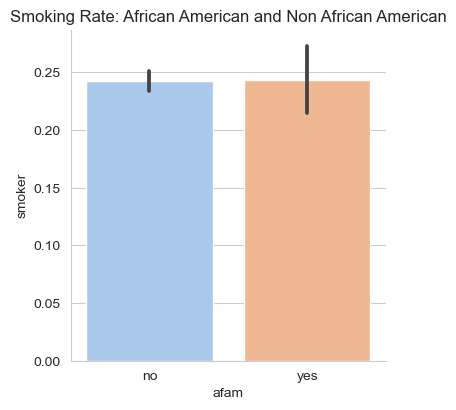

In [13]:
sns.catplot(data = num_df, x = 'afam', y= 'smoker', kind = 'bar', height = 4, aspect = 1)
plt.title("Smoking Rate: African American and Non African American")
plt.show()

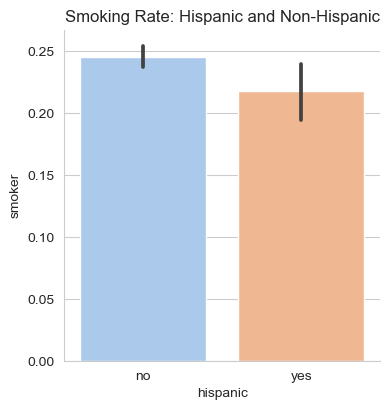

In [14]:
sns.catplot(data = num_df, x = 'hispanic', y = 'smoker', kind = 'bar', height = 4, aspect = 1)
plt.title("Smoking Rate: Hispanic and Non-Hispanic")
plt.show()

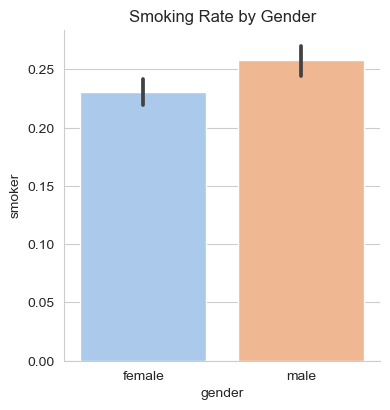

In [15]:
sns.catplot(data = num_df, x = 'gender', y = 'smoker', kind = 'bar', height = 4, aspect = 1)
plt.title("Smoking Rate by Gender")
plt.show()

<h3>Effect of Gender, Race, and Ethnicity on Smoking Rate</h3>
<p>Gender, race, and ethnicity do not seem to play a significant role in whether or not an individual is a smoker.  Therefore, we will leave these variables out when building our predictive model.</p>

# Continuous Variable Exploration

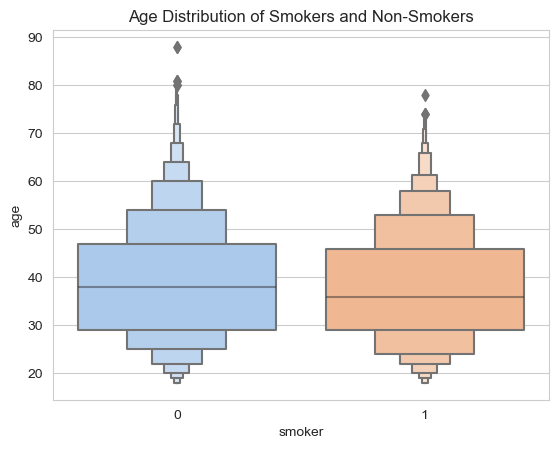

In [16]:
sns.boxenplot(data = num_df, x = 'smoker', y = 'age')
plt.title("Age Distribution of Smokers and Non-Smokers")
plt.show()

# Predictive Modeling

<p style="color: blue; font-size: 16px;">Our variable exploration has helped identify which variables we will want to include when building a predictive model.  The only two variables in our dataset that correlate with smoking rate are level of education and workplace ban.  Thus, these will be the only two variables used in our predictive model</p>

<h4>Input Variables</h4>
<ol>
    <li>Ban</li>
    <li>Education</li>
</ol>
<h4>Target Variable</h4>
<ul>
    <li>Smoke</li>
</ul>

In [17]:
num_df.head()

,smoker,ban,age,education,afam,hispanic,gender
0,1,1,41,hs,no,no,female
1,1,1,44,some college,no,no,female
2,0,0,19,some college,no,no,female
3,1,0,29,hs,no,no,female
4,0,1,28,some college,no,no,female


## Using one Hot Encoded Columns

In [18]:
# building pipeline to transform input variables
cat_attribute = num_df[['education']]

pipeline = Pipeline([
    ('One hot encoding', OneHotEncoder())
])

cat_tr = pipeline.fit_transform(cat_attribute)
cat_tr = cat_tr.toarray() # numpy array of one hot encoded values

ban_attribute = np.array(num_df['ban']).reshape(-1, 1) # numpy array of workplace ban

predictors = np.concatenate((cat_tr, ban_attribute), axis = 1) # concatentate two variables to form prediction dataset
predictors

array([[0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1.]])

In [19]:
X = predictors
y = num_df['smoker']

# split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)

In [20]:
# define and train model

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
# make predictions
rf_predictions = rf.predict(X_test)

# assess results
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = precision_score(y_test, rf_predictions)

C:\Users\schle\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schle\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_predictions = xgb.predict(X_test)

# assess results
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = precision_score(y_test, xgb_predictions)

C:\Users\schle\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\schle\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Results

In [23]:
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)

Random Forest Accuracy: 0.772
Random Forest Precision: 0.0
Random Forest Recall: 0.0


In [24]:
print("Random Forest Accuracy:", xgb_accuracy)
print("Random Forest Precision:", xgb_precision)
print("Random Forest Recall:", xgb_recall)

Random Forest Accuracy: 0.772
Random Forest Precision: 0.0
Random Forest Recall: 0.0


<p style = "color: blue; font-size: 16px;">Unfortunately, we are not able to build a reliable predictive model.  Although our model is fairly accurate, it is not able to predict when someone will be a smoker.</p>